In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import glob
import json
import string
import sys

import numpy as np
from scipy.interpolate import griddata
from scipy import io
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import superscreen as sc

sys.path.append("../code")
from scripts import squid_susc_fc_ac
from squids import hypres

# figure_dir = None
figure_dir = "../latex/figures"

In [2]:
def loadmat(fname):
    return io.loadmat(fname, simplify_cells=True)

def get_index(fname):
    return int(fname.split("_")[0][1:])

In [3]:
datadir = os.path.join(
    os.pardir,
    "data",
    "measurement",
    "slot",
    "2019-10-26",
)

In [4]:
datasets = sorted(os.listdir(datadir), key=get_index)

In [5]:
start, stop = 48, 60

In [6]:
ref_mat = loadmat(os.path.join(datadir, os.pardir, "2019-10-27", "#004_scan_01-02-57", "scan0.mat"))
suscx = ref_mat["SUSCX"]["array"].T
suscy = ref_mat["SUSCY"]["array"].T

M_inf = (suscx + 1j * suscy).mean()
M_inf_std = (suscx + 1j * suscy).std()
print(M_inf, M_inf_std)

(280.88710758516567+0.674239304724541j) 0.06909239172911667


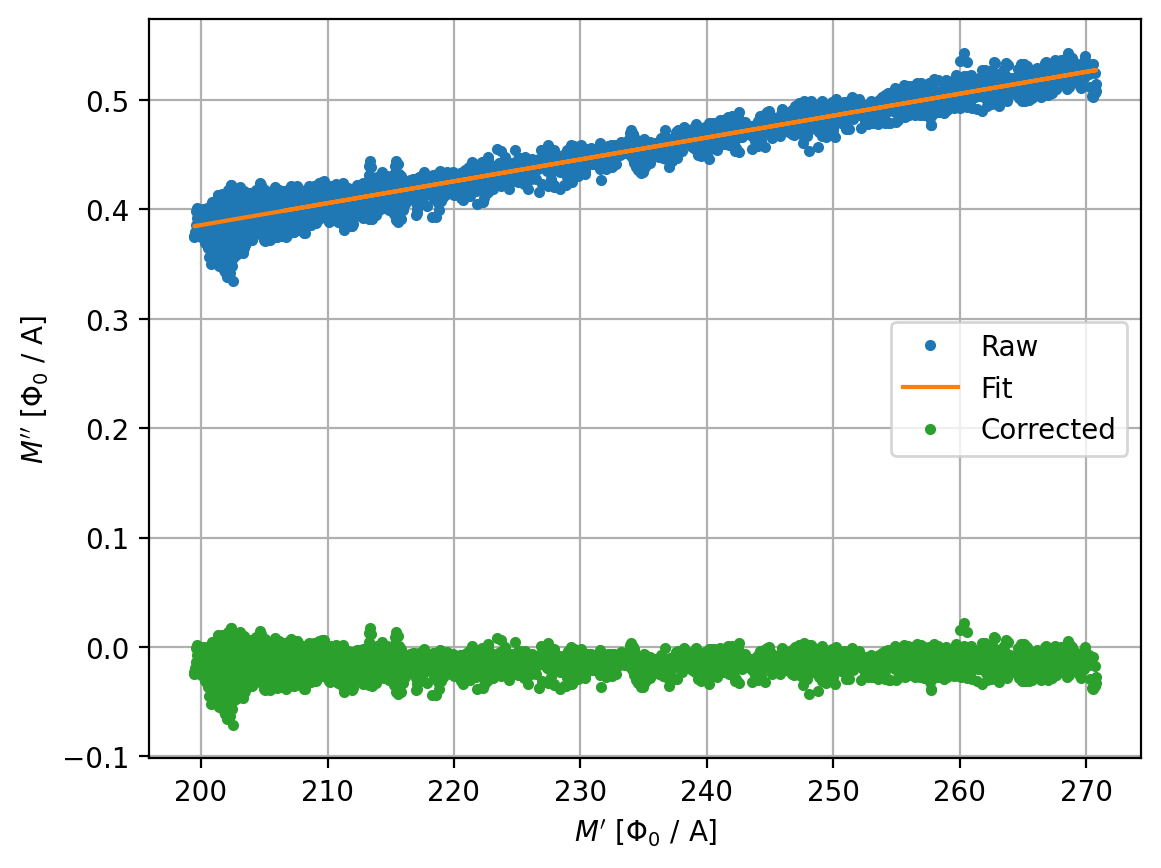

In [7]:
mat = loadmat(os.path.join(datadir, datasets[start-1], "scan0.mat"))
suscx = mat["SUSCX"]["array"]
suscy = mat["SUSCY"]["array"]
              
fig, ax = plt.subplots()
sx = suscx.ravel()
sy = suscy.ravel()
ax.plot(sx, sy, ".", label="Raw")
slope, ofs = np.polyfit(sx, sy, 1)
ax.plot(sx, slope * sx + ofs, "-", label="Fit")
angle = np.arctan(slope)
M = (suscx + 1j * suscy) * np.exp(-1j * angle)
ax.plot(M.real.ravel(), M.imag.ravel(), ".", label="Corrected")
ax.legend(loc=0)
ax.set_xlabel("$M'$ [$\\Phi_0$ / A]")
ax.set_ylabel("$M''$ [$\\Phi_0$ / A]")
ax.grid(True)

In [8]:
results = {}
for i in range(start-1, stop):
    mat = loadmat(os.path.join(datadir, datasets[i], "scan0.mat"))
    suscx = mat["SUSCX"]["array"]
    suscy = mat["SUSCY"]["array"]
    M = (suscx + 1j * suscy) * np.exp(-1j * angle) - M_inf
    xcap = mat["x_cap"]["array"]
    ycap = mat["y_cap"]["array"]
    xcap = 1e3 * (xcap - xcap.mean())
    ycap = 1e3 * (ycap - ycap.mean())
    key = mat["temperature"]
    # Linearly interpolate data to a regular grid
    x = np.linspace(-12, 12, 101)
    y = np.linspace(-12, 12, 101)
    X, Y = np.meshgrid(x, y)
    points = np.array([xcap.ravel(), ycap.ravel()]).T
    values = M.ravel()
    Mgrid = griddata(points, values, (X, Y), method="linear")
    results[key] = (X, Y, Mgrid)

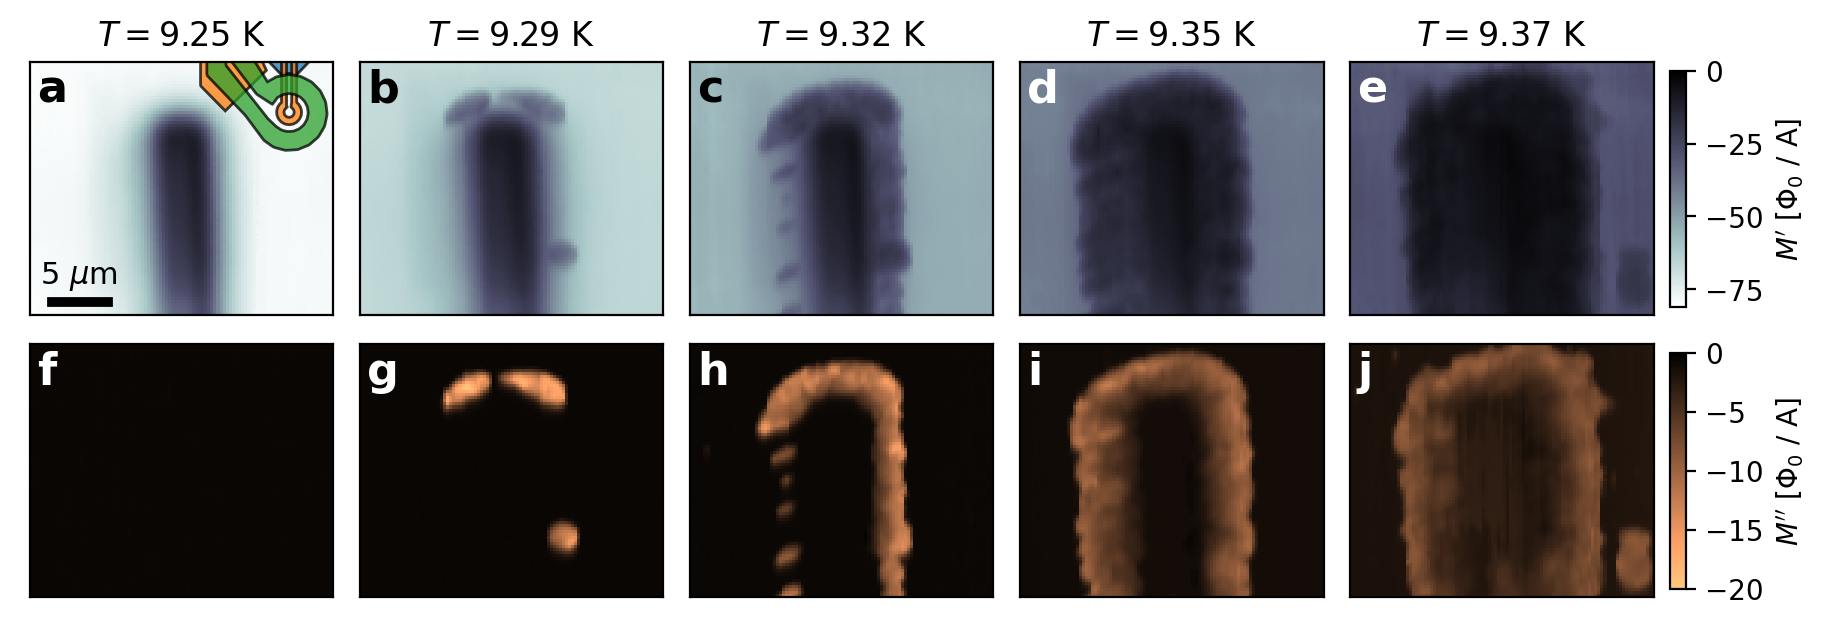

In [9]:
temps = [9.25, 9.29, 9.32, 9.35, 9.37]

fig, axes = plt.subplots(
    2, len(temps), figsize=(9, 3),
    sharex=True, sharey=True, constrained_layout=True
)

for ax in axes.flat:
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    
for (ax, bx), temp in zip(axes.T, temps):
    xcap, ycap, M = results[temp]
    ax.set_title(f"$T = ${temp} K")
    ax.set_xlim(-12, 12)
    ax.set_ylim(-10, 10)
    im_real = ax.pcolormesh(xcap, ycap, M.real, cmap="bone_r", vmin=-81, vmax=0)
    im_imag = bx.pcolormesh(xcap, ycap, M.imag, cmap="copper_r", vmin=-20, vmax=0)
    
cbar_real = fig.colorbar(im_real, ax=axes[0], pad=1e-2, shrink=0.9, aspect=15)
cbar_real.set_label("$M'$ [$\\Phi_0$ / A]")
cbar_imag = fig.colorbar(im_imag, ax=axes[1], pad=1e-2, shrink=0.9, aspect=15)
cbar_imag.set_label("$M''$ [$\\Phi_0$ / A]")


squid = hypres.small.make_squid().rotate(180).translate(dx=8.5, dy=6)

ax = axes[0, 0]
xlim = ax.get_xlim()
ylim = ax.get_ylim()
squid.draw(ax=ax, exclude="bounding_box", legend=False, alpha=0.75, layer_order="increasing")
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_xlabel("")
ax.set_ylabel("")
    
for ax, color in zip(axes[:, 0], "k"):

    scalebar = AnchoredSizeBar(
        ax.transData,
        5, "5 $\\mu$m",
        "lower left",
        frameon=False,
        color=color,
        label_top=True,
        size_vertical=0.5,
        pad=0.25,
        fontproperties=fm.FontProperties(size=11)
    )
    ax.add_artist(scalebar)
    
for ax, letter, color in zip(axes.flat, string.ascii_lowercase, "kkkwwwwwww"):
    ax.text(0.025, 0.975, letter, size=16, color=color, ha="left", va="top", weight="bold", transform=ax.transAxes)
    
if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "susc_Tseries_scans-3.png"), dpi=400, bbox_inches="tight")

In [10]:
def process_run(run_name):
    paths = sorted(
        glob.glob(f"../data/simulation/{run_name}/*/results.json"),
        key=lambda path: int(path.split("/")[-2]),
    )
    with open(paths[0], "r") as f:
        args = json.load(f)["args"]
        
    num_cycles = args["cycles"]
    pts_per_cycle = args["points_per_cycle"]
    pts = int(num_cycles * pts_per_cycle)
    cycles = np.linspace(0, num_cycles, pts)
    phase = np.exp(-1j * 2 * np.pi * cycles)
    xstart, xstop, xnum = args["slot_top_center_x"]
    ystart, ystop, ynum = args["slot_top_center_y"]
    xs = np.linspace(xstart, xstop, int(xnum))
    ys = np.linspace(ystart, ystop, int(ynum))
    coords = np.array([xs, ys]).T
    I_fc = args["I_fc"][0]
    ix = slice(int(pts_per_cycle * 0.5), None)
    
    susc = []
    indices = []
    
    for path in paths:
        with open(path, "r") as f:
            try:
                result = json.load(f)
            except:
                continue
        index = result["args"]["index"]
        indices.append(index)
        current = I_fc * phase.real
        flux = np.array(result["flux"])
        susc.append(np.sqrt(2) * np.trapz(phase[ix] * flux[ix]) / (1e-3 * I_fc) / len(flux[ix]))
        
    susc = np.array(susc)
    return coords[indices], susc


{'num_sites': 5123, 'num_elements': 9744, 'min_edge_length': 0.1941967904709809, 'max_edge_length': 0.7558403360195729, 'mean_edge_length': 0.43955863575835824, 'min_area': 0.018669289123345496, 'max_area': 0.35772790681591976, 'mean_area': 0.1613450554346385, 'coherence_length': 0.9, 'length_units': 'um'}


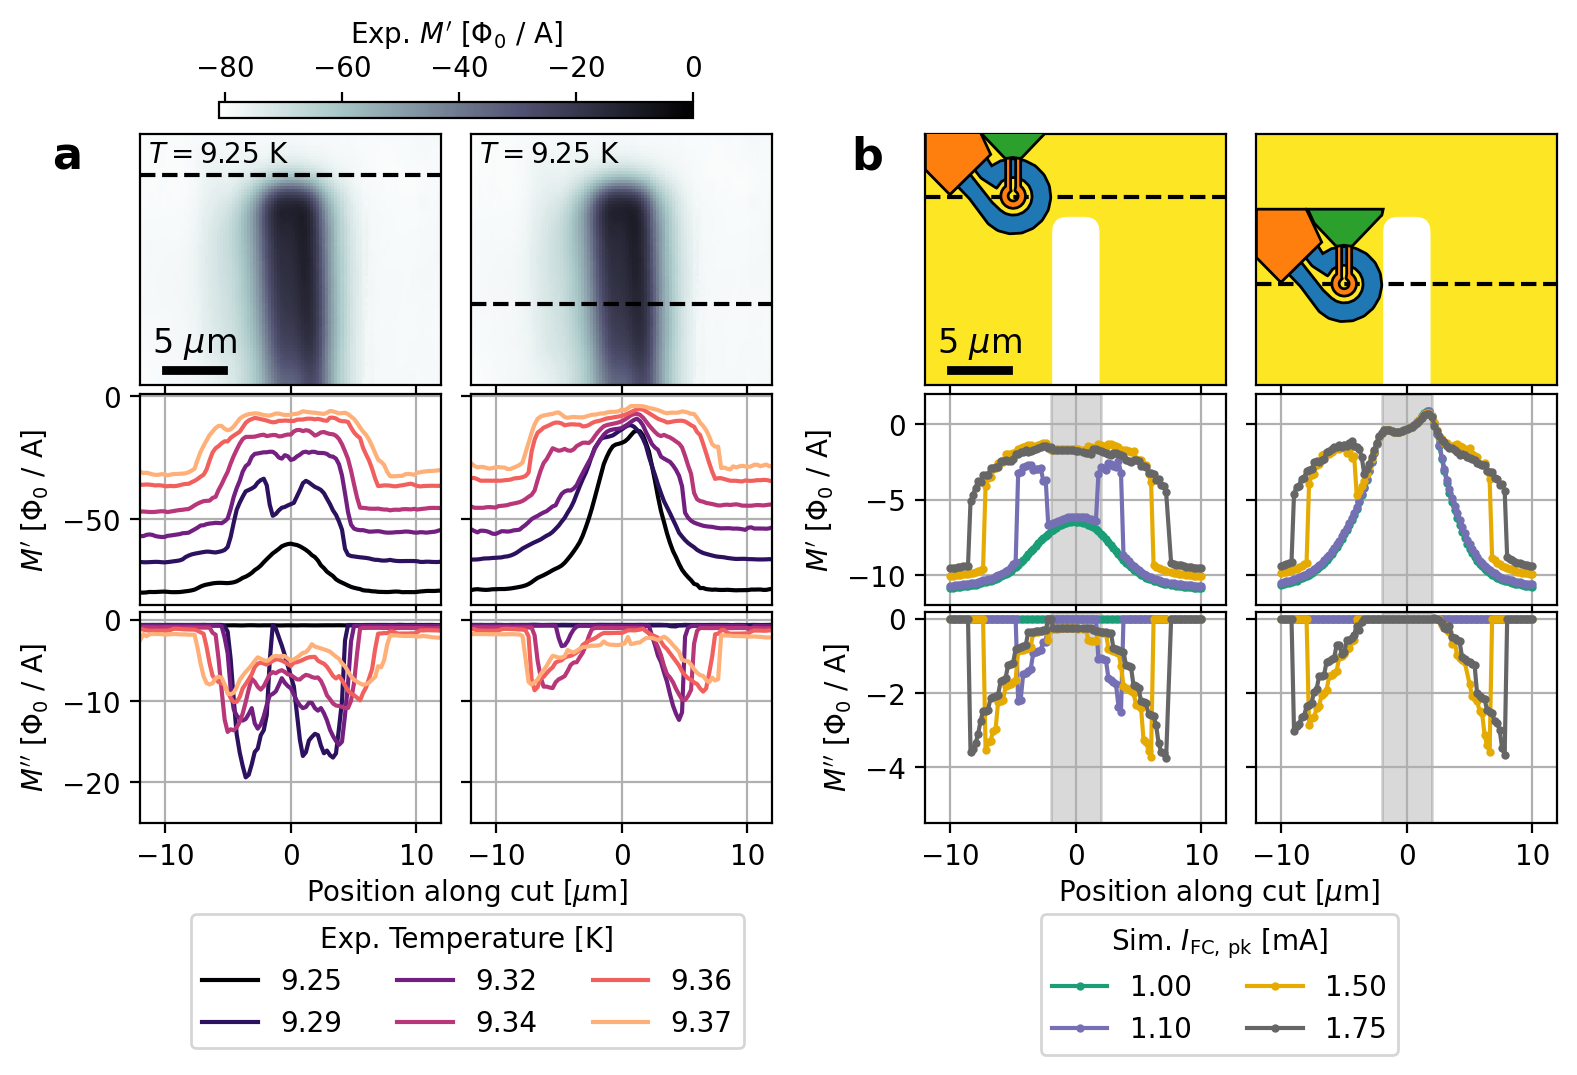

In [11]:
plt.rcParams["font.size"] = 10

temps = [9.25, 9.29, 9.32, 9.34, 9.36, 9.37]

fig = plt.figure(figsize=(8, 4.3), constrained_layout=True)

gs = fig.add_gridspec(1, 2)
gs0 = gs[0].subgridspec(3, 2, wspace=0.1, hspace=0.025, height_ratios=[1.5, 1, 1])
gs1 = gs[1].subgridspec(3, 2, wspace=0.1, hspace=0.025, height_ratios=[1.5, 1, 1])

axes = np.array([[fig.add_subplot(gs0[i, j]) for j in range(2)] for i in range(3)])
bxes = np.array([[fig.add_subplot(gs1[i, j]) for j in range(2)] for i in range(3)])

slot_y0 = 3

tdgl_device = squid_susc_fc_ac.make_film_with_slot(
    radius=15,
    xi=0.9,
    lambda_=1.35,
    d=0.2,
    min_points=5000,
    smooth=100,
    slot_size=(4, 50),
    slot_top_center=(0, slot_y0),
    slot_radius=1,
    shape="box",
)

squid = squid_susc_fc_ac.squid_funcs["hypres-small"]().rotate(180)
    
cut_rows = [78, 35]

colors = plt.get_cmap("magma")(np.linspace(0, 1, len(temps) + 1))

for subplot in [axes, bxes]:
    for ax in subplot[0]:
        ax.set_aspect("equal")
        ax.set_yticks([])
        ax.set_ylim(-10, 10)
    
    for ax in subplot[:-1, 0]:
        if ax is not subplot[-1, 0]:
            ax.sharex(subplot[-1, 0])
    
    for ax in subplot[:-1, 1]:
        if ax is not subplot[-1, 1]:
            ax.sharex(subplot[-1, 1])
            
    for ax in subplot[1:].flat:
        ax.grid(True)
        
    for ax in subplot[-1, :2]:
        ax.set_xlim(-12, 12)
      
    subplot[1, 0].set_ylabel("$M'$ [$\\Phi_0$ / A]")
    subplot[2, 0].set_ylabel("$M''$ [$\\Phi_0$ / A]")

sim_runs = [
    {
        1.0: "11376733",
        1.1: "11204356",
        # 1.25: "11390305",
        1.5: "11280881",
        1.75: "11390289",
    },
    {
        1.0: "11376781",
        1.1: "11233444",
        # 1.25: "11390407",
        1.5: "11280832",
        1.75: "11390273",
    },
]

for ax, (slot_y) in zip(bxes[0], [-2, 5]):
    line = ax.axhline(slot_y0 - slot_y, color="k", ls="--")
    patch = tdgl_device.patches()["film"]
    patch.set_color(plt.get_cmap("viridis").get_over())
    ax.add_patch(patch)
    
    squid.translate(dx=-5, dy=slot_y0 - slot_y).draw(
        ax=ax, exclude="bounding_box", alpha=1, layer_order="decreasing"
    )
    for patch in ax.patches[1:]:
        patch.set_zorder(5)
    
    ax.set_ylabel("")
    ax.set_xlabel("")
    
for ax in bxes[1:].flat:
    ax.axvspan(-2, 2, color="k", alpha=0.15)
    
sim_colors = plt.get_cmap("Dark2")(np.linspace(0, 1, len(sim_runs[0])))

for j, cut_row in enumerate(cut_rows):
    
    for i, temp in enumerate(temps):
        xcap, ycap, M = results[temp]
        if i == 0:
            ax = axes[0, j]
            im_real = ax.pcolormesh(xcap, ycap, M.real, cmap="bone_r", vmin=-81, vmax=0)
            ax.plot(xcap[cut_row], ycap[cut_row], color="k", ls="--")
            ax.text(0.025, 0.975, f"$T=${temp:.2f} K", transform=ax.transAxes, ha="left", va="top")
        axes[1, j].plot(xcap[cut_row], M[cut_row].real, "-", color=colors[i], label=f"{temp:.2f}")
        axes[2, j].plot(xcap[cut_row], M[cut_row].imag, "-", color=colors[i])
        
    runs = sim_runs[j]
    for k, (current, run) in enumerate(runs.items()):
        coords, susc = process_run(run)
        color = sim_colors[k]
        bxes[1, j].plot(coords[:, 0], susc.real, ".-", color=color, label=f"{current:.2f}", markersize=4)
        bxes[2, j].plot(coords[:, 0], susc.imag, ".-", color=color, markersize=4)        

for ax in axes[1, :]:
    ax.set_ylim(-85, 1)
for ax in axes[2, :]:
    ax.set_ylim(-25, 1)
for ax in bxes[1, :]:
    ax.set_ylim(-12, 2)
for ax in bxes[2, :]:
    ax.set_ylim(-5.5, 0.2)
for ax in bxes[0]:
    ax.set_xlim(-12, 12)
    ax.set_ylim(-10, 10)
    
handles, labels = axes[1, j].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center", bbox_to_anchor=(0.3, 0),
    ncols=3,
    title="Exp. Temperature [K]",
)

handles, labels = bxes[1, j].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center", bbox_to_anchor=(0.77, 0),
    ncols=2,
    title="Sim. $I_{\\mathrm{FC},\\,\\mathrm{pk}}$ [mA]",
)

axes[1, 1].yaxis.set_ticklabels([])
axes[2, 1].yaxis.set_ticklabels([])
bxes[1, 1].yaxis.set_ticklabels([])
bxes[2, 1].yaxis.set_ticklabels([])

fig.text(0.3, 0, "Position along cut [$\\mu$m]", ha="center")
fig.text(0.77, 0, "Position along cut [$\\mu$m]", ha="center")

for ax in [axes[0, 0], bxes[0, 0]]:
    scalebar = AnchoredSizeBar(
        ax.transData,
        5, "5 $\\mu$m",
        "lower left",
        frameon=False,
        color="k",
        label_top=True,
        size_vertical=0.5,
        pad=0.25,
        fontproperties=fm.FontProperties(size=12)
    )
    ax.add_artist(scalebar)

fig.tight_layout()

cbar0 = fig.colorbar(im_real, ax=axes[0], location="top", orientation="horizontal", aspect=30, shrink=0.75)
cbar0.set_label("Exp. $M'$ [$\\Phi_0$ / A]")

cbar1 = fig.colorbar(im_real, ax=bxes[0], location="top", orientation="horizontal", aspect=30, shrink=0.75)
fig.delaxes(cbar1.ax)

fig.text(0.05, 0.89, "a", weight="bold", ha="center", va="top", size=16)
fig.text(0.55, 0.89, "b", weight="bold", ha="center", va="top", size=16)

if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "slot-sim-cuts.png"), dpi=300, bbox_inches="tight")